In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib as plt
import stock_utils as su
%matplotlib inline

In [37]:
# We will look at stock prices over the past year, starting at January 1, 2016
start_date = datetime.datetime(2016, 1, 1)
end_date = datetime.datetime(2016, 12, 31)
# end_date = datetime.date.today()

# tickers = ['AAPL', 'MSFT', 'GOOG', 'FB', 'AMZN']
tickers = ['AAPL', 'MSFT', 'GOOG']

In [5]:
su.download_data(tickers, start, end)

Saving to data/AAPL.csv
Saving to data/MSFT.csv
Saving to data/GOOG.csv
Saving to data/FB.csv
Saving to data/AMZN.csv
Saving to data/SPY.csv


In [38]:
data_frame = pd.read_csv(su.symbol_to_path(tickers[0]),
      index_col = 'Date',
      parse_dates = True,
      na_values = ['NaN'])
data_frame.head()

,Open,High,Low,Close,Volume
Date,,,,,
2016-01-04,102.61,105.37,102.00,105.35,67281190
2016-01-05,105.75,105.85,102.41,102.71,55790992
2016-01-06,100.56,102.37,99.87,100.70,68457388
2016-01-07,98.68,100.13,96.43,96.45,81094428
2016-01-08,98.55,99.11,96.76,96.96,70798016


In [39]:
data_frame.describe()

,Open,High,Low,Close,Volume
count,391.000000,391.000000,391.000000,391.000000,3.910000e+02
mean,117.268824,118.174655,116.468031,117.394987,3.410247e+07
std,19.350060,19.330110,19.340462,19.362961,1.623213e+07
min,90.000000,91.670000,89.470000,90.340000,1.147592e+07
25%,100.415000,101.325000,99.290000,100.470000,2.406715e+07
50%,111.360000,112.300000,110.330000,111.570000,2.921912e+07
75%,138.760000,139.395000,138.095000,138.975000,3.817630e+07
max,156.010000,156.650000,155.050000,156.100000,1.322245e+08


## SP500 price for the period

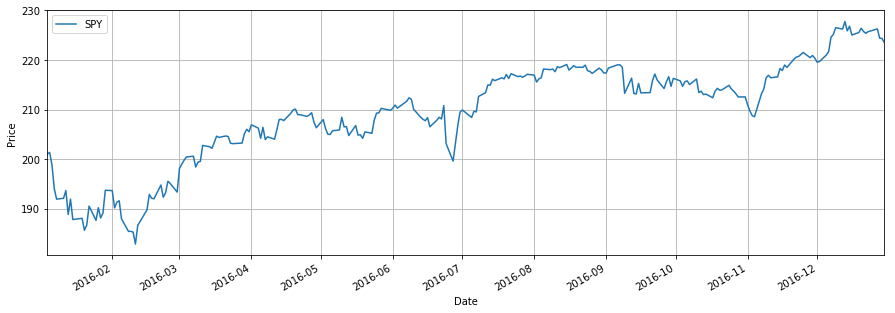

In [40]:
# start_date = '2016-01-01'
# end_date = '2016-01-31'

data_frame = su.spy_data_frame(start_date, end_date)
ax = data_frame.plot(figsize=(15,5), grid = True)

ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend(loc='upper left')

## Normalized prices for selected stocks

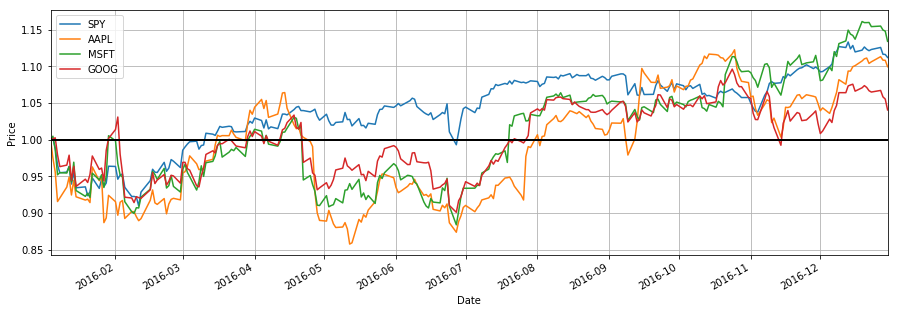

In [41]:
data_frame = su.get_data_frame_for_symbols(tickers, start_date, end_date)

data_frame = su.normalize_data(data_frame)
ax = data_frame.plot(figsize=(15,5), grid = True)

ax.axhline(y = 1, color = 'black', lw = 2)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend(loc='upper left')

## Daily returns for selected stocks

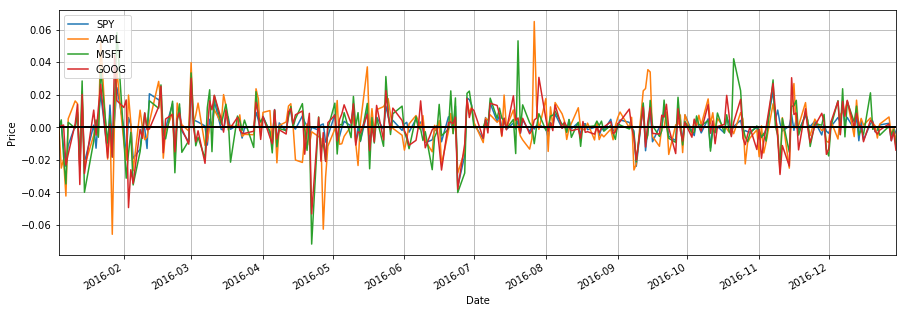

In [42]:
data_frame = su.get_data_frame_for_symbols(tickers, start_date, end_date)

daily_returns = su.compute_daily_returns(data_frame)
ax = daily_returns.plot(figsize=(15,5), grid = True)

ax.axhline(y = 0, color = 'black', lw = 2)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend(loc='upper left')

## Cummulative returns (in percentage) at the end of the period for selected stocks

In [43]:
data_frame = su.get_data_frame_for_symbols(tickers, start_date, end_date)

cummulative_returns = su.compute_cummulative_returns(data_frame)

print(cummulative_returns.ix[-1, :])

SPY     0.111979
AAPL    0.099383
MSFT    0.133942
GOOG    0.040413
Name: 2016-12-30 00:00:00, dtype: float64
